## Stacked LSTM Stock Price Prediction

In [1]:
import pandas_datareader as pdr

C:\Users\harshvardhan\Anaconda3\envs\tensorflow\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
# Use the Tingo API key to connect 
df = pdr.get_data_tiingo('AAPL', api_key=key)
df.to_csv('AAPL.csv')

In [5]:
import pandas as pd
df=pd.read_csv(r'D:\Python DataScience\Stock-MArket-Forecasting-master\AAPL.csv')

In [6]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [7]:
df1=df.reset_index()['close']

In [8]:
df1.head()

0    132.045
1    131.780
2    130.280
3    130.535
4    129.960
Name: close, dtype: float64

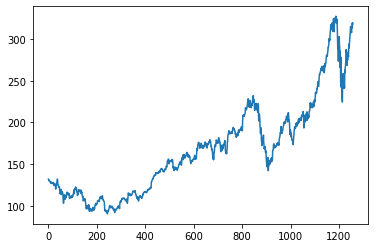

In [9]:
import matplotlib.pyplot as plt 
plt.plot(df1)

### LSTM are sensitive to the scale of the data. so we apply MinMax scaler


In [11]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


In case of time series data we should use a different approach to do a train test split, because in time series the data is dependent on the past values, so we will have to split in series according to the date.
In short we should do a sequential splitting.

In [12]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(817, 441)

**So now here we do some data preprocessing.**<br>

Lets say our data is <br>
Training Data = [120,130,125,140,134,150]<br>
Testing Data = [160,190,154]<br>

So here we need to select a timestamp , a timestamp denotes that how mnay days in past we have to select to predict the current days answer. <br>

Initially we select three days and predict the 4th and similary we slide the window further.

<html>
<body>

<h2>Data Format</h2>

<table style="width:100%">
  <tr>
    <th>F1</th>
    <th>F2</th> 
    <th>F3</th>
    <th>OUTPUT</th>
      
  </tr>
  <tr>
    <td>120</td>
    <td>130</td>
    <td>125</td>
    <td>140</td>
  </tr>
  <tr>
    <td>130</td>
    <td>125</td>
    <td>140</td>
    <td>134</td>
    </tr>
</table>

</body>
</html>


In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
X_train.shape,y_train.shape

((716, 100), (716,))

In [24]:
X_test.shape, ytest.shape

((340, 100), (340,))

In [25]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [26]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [27]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Train on 716 samples, validate on 340 samples
Epoch 1/100
716/716 [==============================] - 76s 106ms/sample - loss: 0.0220 - val_loss: 0.0491
Epoch 2/100
716/716 [==============================] - 1s 1ms/sample - loss: 0.0031 - val_loss: 0.0050
Epoch 3/100
716/716 [==============================] - 1s 877us/sample - loss: 0.0010 - val_loss: 0.0106
Epoch 4/100
716/716 [==============================] - 1s 824us/sample - loss: 8.0191e-04 - val_loss: 0.0040
Epoch 5/100
716/716 [==============================] - 1s 875us/sample - loss: 7.4921e-04 - val_loss: 0.0041
Epoch 6/100
716/716 [==============================] - 1s 848us/sample - loss: 6.7433e-04 - val_loss: 0.0042
Epoch 7/100
716/716 [==============================] - 1s 956us/sample - loss: 6.2836e-04 - val_loss: 0.0039
Epoch 8/100
716/716 [==============================] - 1s 1ms/sample - loss: 6.2582e-04 - val_loss: 0.0038
Epoch 9/100
716/716 [==============================] - 1s 974us/sample - loss: 6.0406e-04 - val_l

716/716 [==============================] - 1s 874us/sample - loss: 2.3036e-04 - val_loss: 0.0012
Epoch 76/100
716/716 [==============================] - 1s 833us/sample - loss: 2.0932e-04 - val_loss: 0.0013
Epoch 77/100
716/716 [==============================] - 1s 1ms/sample - loss: 2.0446e-04 - val_loss: 0.0010
Epoch 78/100
716/716 [==============================] - 1s 946us/sample - loss: 2.0700e-04 - val_loss: 0.0014
Epoch 79/100
716/716 [==============================] - 1s 893us/sample - loss: 2.0375e-04 - val_loss: 0.0014
Epoch 80/100
716/716 [==============================] - 1s 845us/sample - loss: 1.9710e-04 - val_loss: 9.8524e-04
Epoch 81/100
716/716 [==============================] - 1s 886us/sample - loss: 2.2002e-04 - val_loss: 0.0021
Epoch 82/100
716/716 [==============================] - 1s 867us/sample - loss: 2.1165e-04 - val_loss: 0.0010
Epoch 83/100
716/716 [==============================] - 1s 916us/sample - loss: 1.9676e-04 - val_loss: 0.0011
Epoch 84/100
716/716 

In [29]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [30]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [31]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

141.00985612615037

In [32]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

233.64683005271837

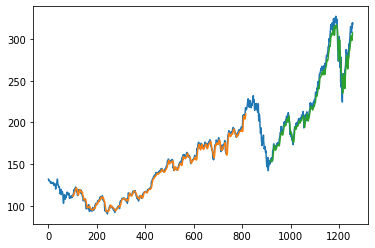

In [34]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [35]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [36]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [37]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9264443]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.9

9 day output [[0.80235034]]
10 day input [0.93304061 0.94950604 0.96424048 0.95512117 0.95989192 0.96635143
 0.96246728 0.92295027 0.9598497  0.98792536 0.98594106 0.92531453
 0.92172591 0.96474711 0.97572406 0.99159841 0.96972895 0.97614625
 0.96795575 1.         0.99016297 0.99050072 0.96538039 0.98488559
 0.97086887 0.94026007 0.87748037 0.83483915 0.85413324 0.77336823
 0.77269273 0.88014017 0.84007431 0.89673225 0.85527316 0.83884995
 0.74233725 0.82327113 0.78143207 0.6665963  0.7921557  0.64118044
 0.68614371 0.66001013 0.65203074 0.58642236 0.56586169 0.66089673
 0.65515494 0.70970193 0.66452757 0.69437642 0.69218104 0.63569197
 0.65266402 0.63780292 0.7267162  0.71388162 0.74191506 0.75002111
 0.77222832 0.83049059 0.8194292  0.8289707  0.8125475  0.78776492
 0.75162543 0.78426074 0.77974331 0.81326522 0.8141096  0.79473106
 0.83336148 0.85898843 0.83901883 0.85628641 0.87486279 0.88782403
 0.90095415 0.92793211 0.948535   0.93333615 0.91746179 0.92544119
 0.91771511 0.9483239

17 day output [[0.7851964]]
18 day input [0.9598497  0.98792536 0.98594106 0.92531453 0.92172591 0.96474711
 0.97572406 0.99159841 0.96972895 0.97614625 0.96795575 1.
 0.99016297 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007
 0.87748037 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017
 0.84007431 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113
 0.78143207 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013
 0.65203074 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193
 0.66452757 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292
 0.7267162  0.71388162 0.74191506 0.75002111 0.77222832 0.83049059
 0.8194292  0.8289707  0.8125475  0.78776492 0.75162543 0.78426074
 0.77974331 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843
 0.83901883 0.85628641 0.87486279 0.88782403 0.90095415 0.92793211
 0.948535   0.93333615 0.91746179 0.92544119 0.91771511 0.9483239
 0.94064004 0.96635143 0.9563033  0.96491598 0.92644429 0.91137475
 0.89010996 0.86885792 0.84979

27 day output [[0.7365576]]
28 day input [0.96795575 1.         0.99016297 0.99050072 0.96538039 0.98488559
 0.97086887 0.94026007 0.87748037 0.83483915 0.85413324 0.77336823
 0.77269273 0.88014017 0.84007431 0.89673225 0.85527316 0.83884995
 0.74233725 0.82327113 0.78143207 0.6665963  0.7921557  0.64118044
 0.68614371 0.66001013 0.65203074 0.58642236 0.56586169 0.66089673
 0.65515494 0.70970193 0.66452757 0.69437642 0.69218104 0.63569197
 0.65266402 0.63780292 0.7267162  0.71388162 0.74191506 0.75002111
 0.77222832 0.83049059 0.8194292  0.8289707  0.8125475  0.78776492
 0.75162543 0.78426074 0.77974331 0.81326522 0.8141096  0.79473106
 0.83336148 0.85898843 0.83901883 0.85628641 0.87486279 0.88782403
 0.90095415 0.92793211 0.948535   0.93333615 0.91746179 0.92544119
 0.91771511 0.9483239  0.94064004 0.96635143 0.9563033  0.96491598
 0.92644429 0.91137475 0.89010996 0.86885792 0.84979099 0.83382636
 0.82131934 0.81220275 0.80608249 0.80235034 0.80029118 0.7991783
 0.79835081 0.79726923

In [38]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

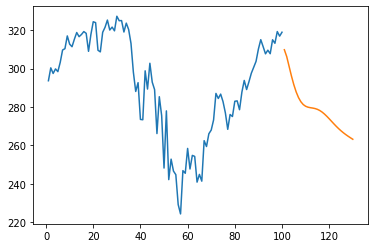

In [39]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

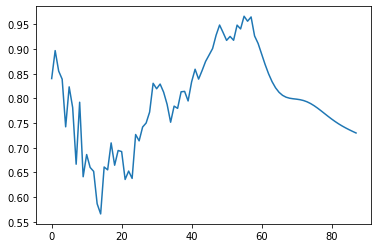

In [40]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

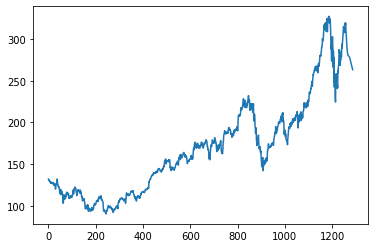

In [41]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)